In [120]:
# !pip3 install missingno
!pip install pandas==1.3.5

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


# Load s3 file

In [1]:
import io
import boto3
import configparser

import numpy as np
import pandas as pd

def read_csv_from_s3(section_name, bucket_name, file_path, ):
    
    parser = configparser.ConfigParser()
    parser.read('./config.ini')
    access_key = parser.get(section_name, "access_key")
    secret_key = parser.get(section_name, "secret_key")
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key, 
                      aws_secret_access_key=secret_key)
    print("Get object")
    obj = s3.get_object(Bucket=bucket_name, Key=file_path)

    print("Read csv")
    df = pd.read_csv( io.BytesIO( obj["Body"].read() ) )
    
    print("Completed")
    print("Data size:", df.shape)

    return df

This notebook was tested on a ml.m5.large notebook instance

In [3]:
section_name = "aws_boto_credentials"
bucket_name = "s3-test-ev"
file_path = "raw/vehicles.csv"

df = read_csv_from_s3(section_name, bucket_name, file_path)

Get object
Read csv
Completed
Data size: (426880, 26)


# EDA (used cars)

In [4]:
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Structure

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

### 1.1. Structure of non-numerical features

In [6]:
df.describe(exclude="number")

,url,region,region_url,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,posting_date
count,426880,426880,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426812,426810,426880,426812
unique,426880,404,413,42,29667,6,8,5,6,3,118264,3,4,13,12,241899,360911,51,381536
top,https://prescott.craigslist.org/cto/d/prescott...,columbus,https://spokane.craigslist.org,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,https://images.craigslist.org/00N0N_1xMPvfxRAI...,35 VEHICLES PRICED UNDER $3000!!! BIG TIME! T...,ca,2021-04-23T22:13:05-0400
freq,1,3608,2988,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,7357,231,50614,12


* url : useless (all unique) -> delete

In [7]:
# uqnique count is less than 10 
cols_few_category = df.columns[df.nunique()<=10]

for col in cols_few_category:
    
    print(col)
    print(df[col].value_counts(dropna=False, normalize=True)*100)
    print("====================")

condition
NaN          40.785232
good         28.452024
excellent    23.769443
like new      4.961113
fair          1.585692
new           0.305707
salvage       0.140789
Name: condition, dtype: float64
cylinders
NaN             41.622470
6 cylinders     22.059829
4 cylinders     18.188250
8 cylinders     16.881091
5 cylinders      0.401049
10 cylinders     0.340845
other            0.304067
3 cylinders      0.153439
12 cylinders     0.048960
Name: cylinders, dtype: float64
fuel
gas         83.444762
other        7.198276
diesel       7.042260
hybrid       1.211113
NaN          0.705819
electric     0.397770
Name: fuel, dtype: float64
title_status
clean         94.901846
NaN            1.930753
rebuilt        1.691108
salvage        0.906109
lien           0.333115
missing        0.190686
parts only     0.046383
Name: title_status, dtype: float64
transmission
automatic    78.833396
other        14.683752
manual        5.884089
NaN           0.598763
Name: transmission, dtype: float64
d

### 1.2. Structure of numerical features

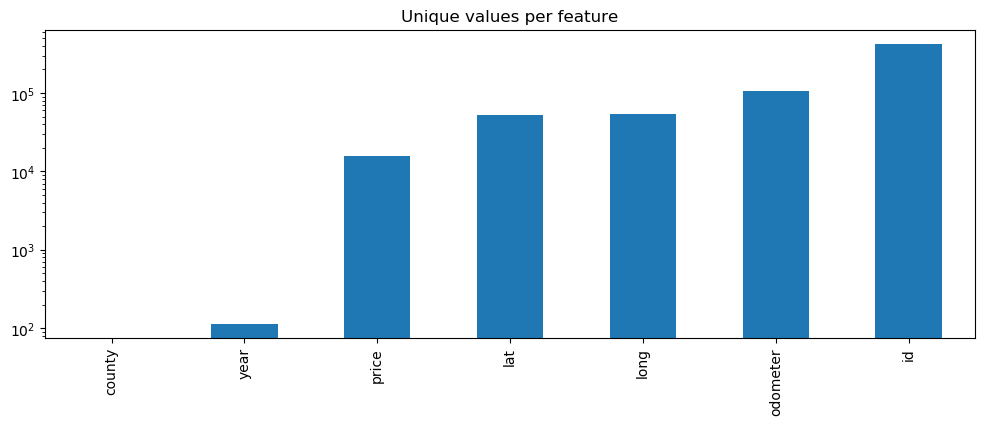

In [8]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(12,4), title="Unique values per feature")
plt.show()

In [9]:
df.select_dtypes(include="number").describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


Range of numeric features
* id : useless (all unique)
* county : useless (all missing) -> delete
* lon, lat : -180 ~ 180, -90 ~ 90
* year : 1900 ~ 2022
* price : 0 ~ 3,700,000,000
* odometer : 0 ~ 10,000,000

## 2. Quality

### 2.1. Missing values

#### 2.1.1. Per sample

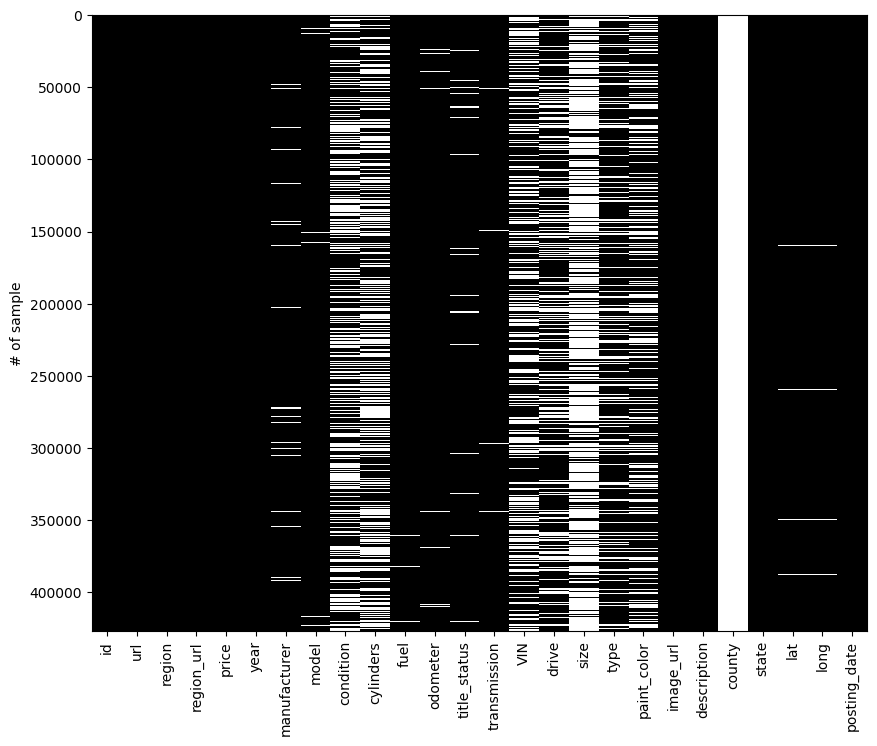

In [10]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.ylabel("# of sample")
plt.xticks(np.arange(df.shape[1]), labels=df.columns, rotation=90)
plt.show()

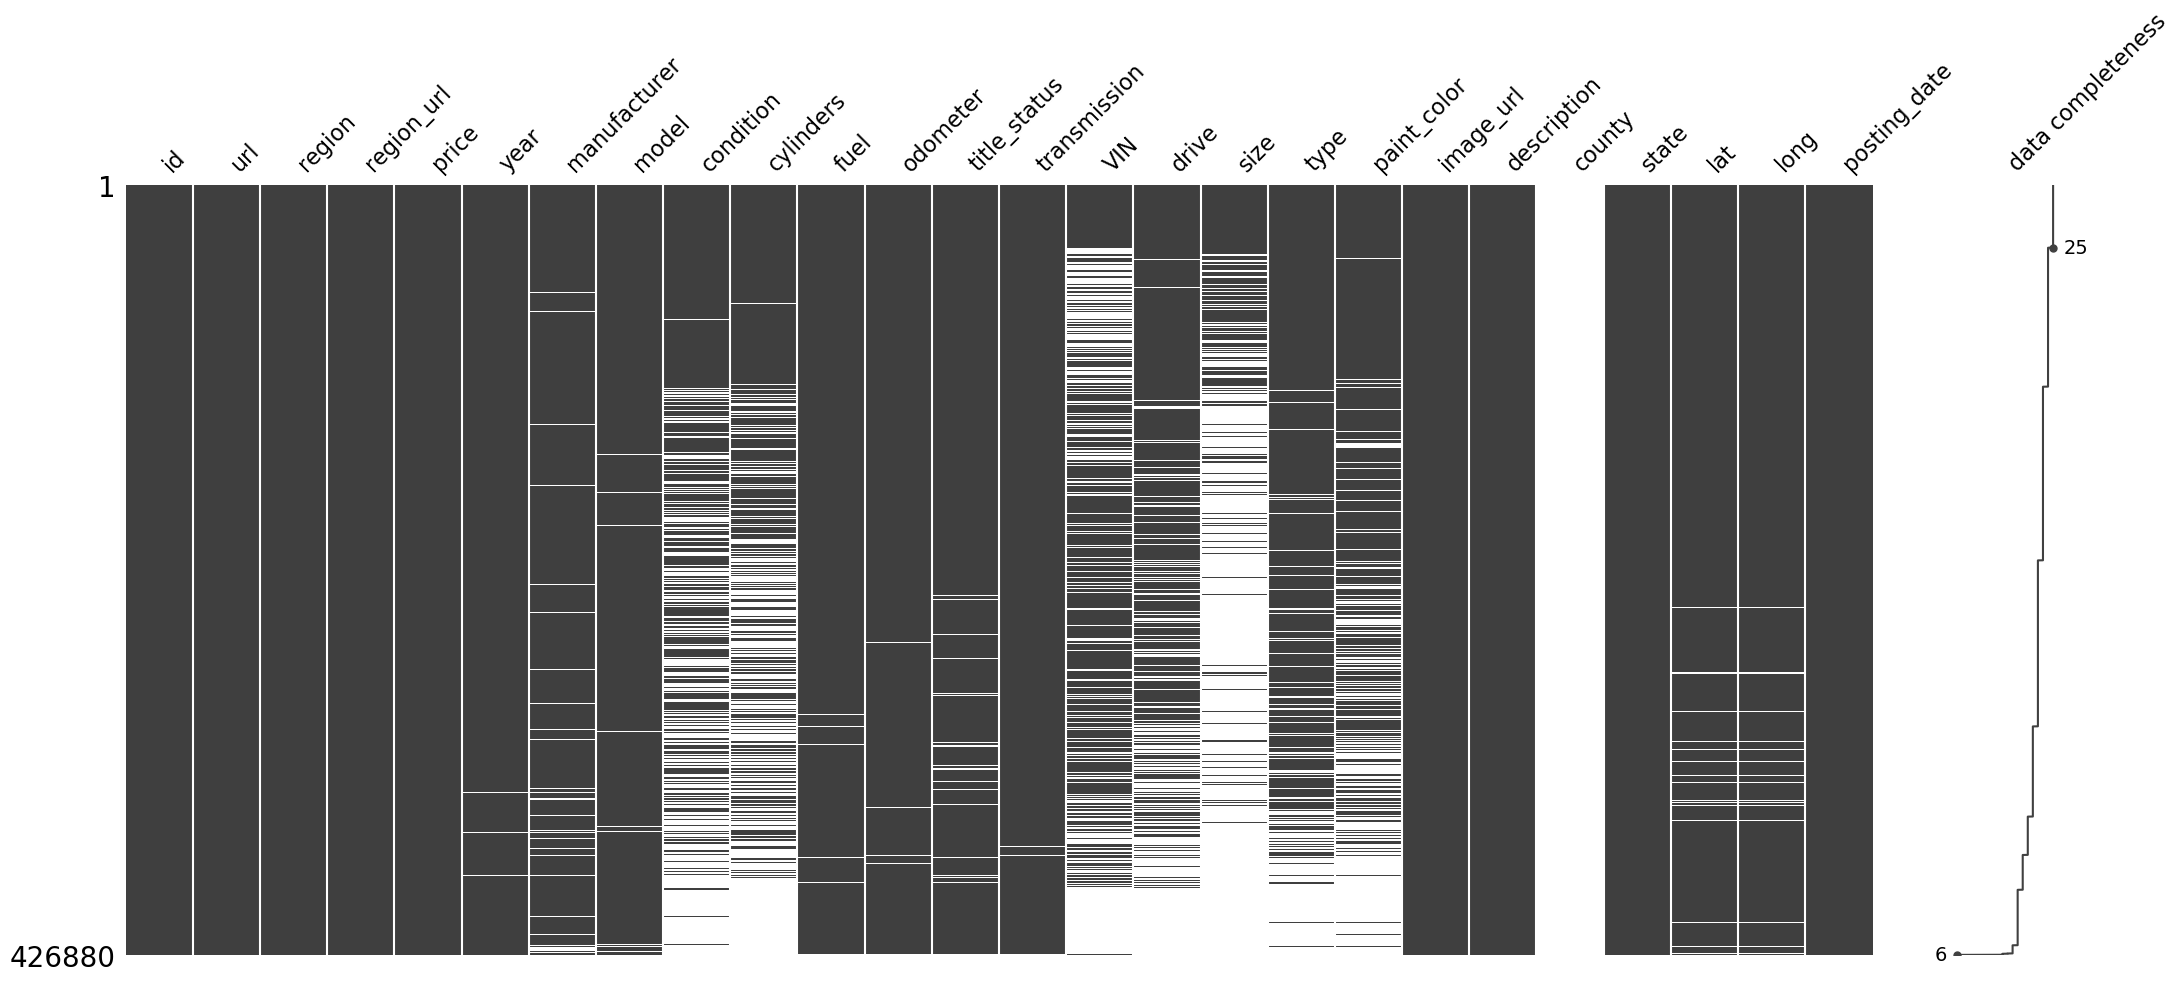

In [11]:
import missingno as msno

msno.matrix(df, labels=True, sort="descending")
plt.show()

#### 2.1.2. Per Feature

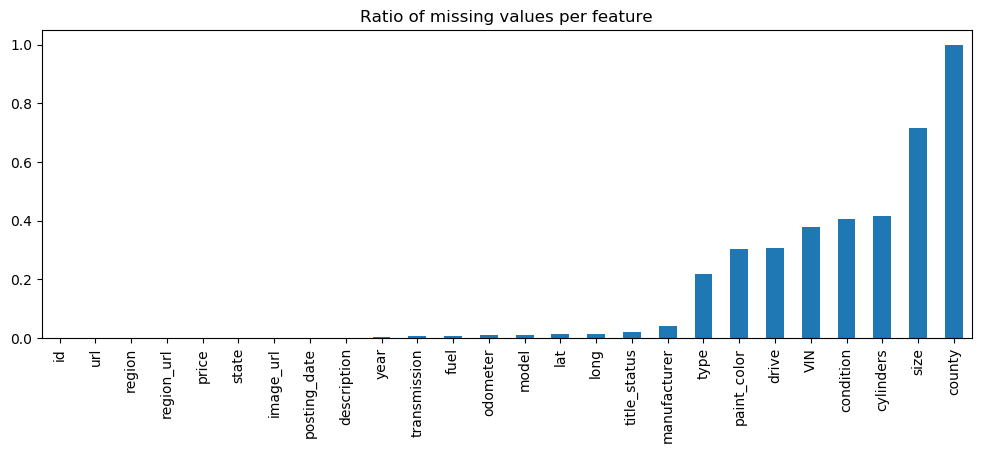

In [12]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(12,4),
    title="Ratio of missing values per feature",
)
plt.show()

### 2.2. Outliers

#### 2.2.1. Numerical features 

No handles with labels found to put in legend.


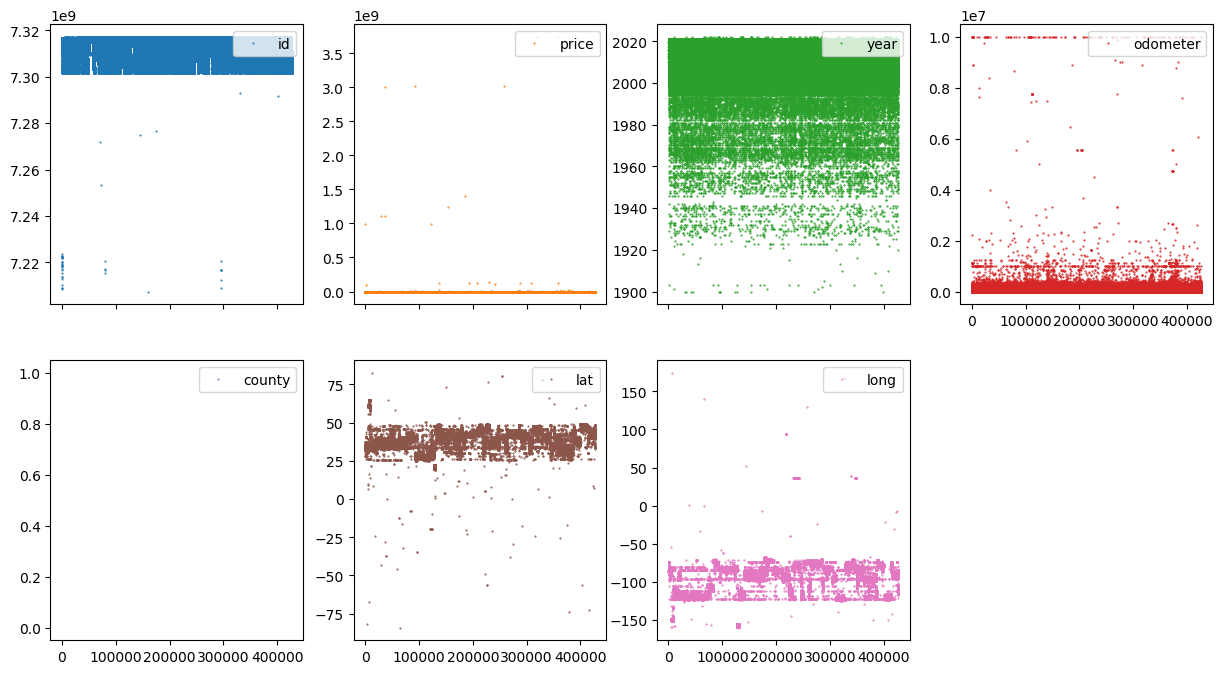

In [13]:
# df.plot(subplots=True) - to plot each feature in a separate subplot

df.plot(lw=0, marker=".", subplots=True, 
        layout=(-1,4), figsize=(15, 8), markersize=1)
for ax in plt.gcf().axes:
    ax.legend(loc=1)
plt.show()

#### 2.2.2. Non-numerical features

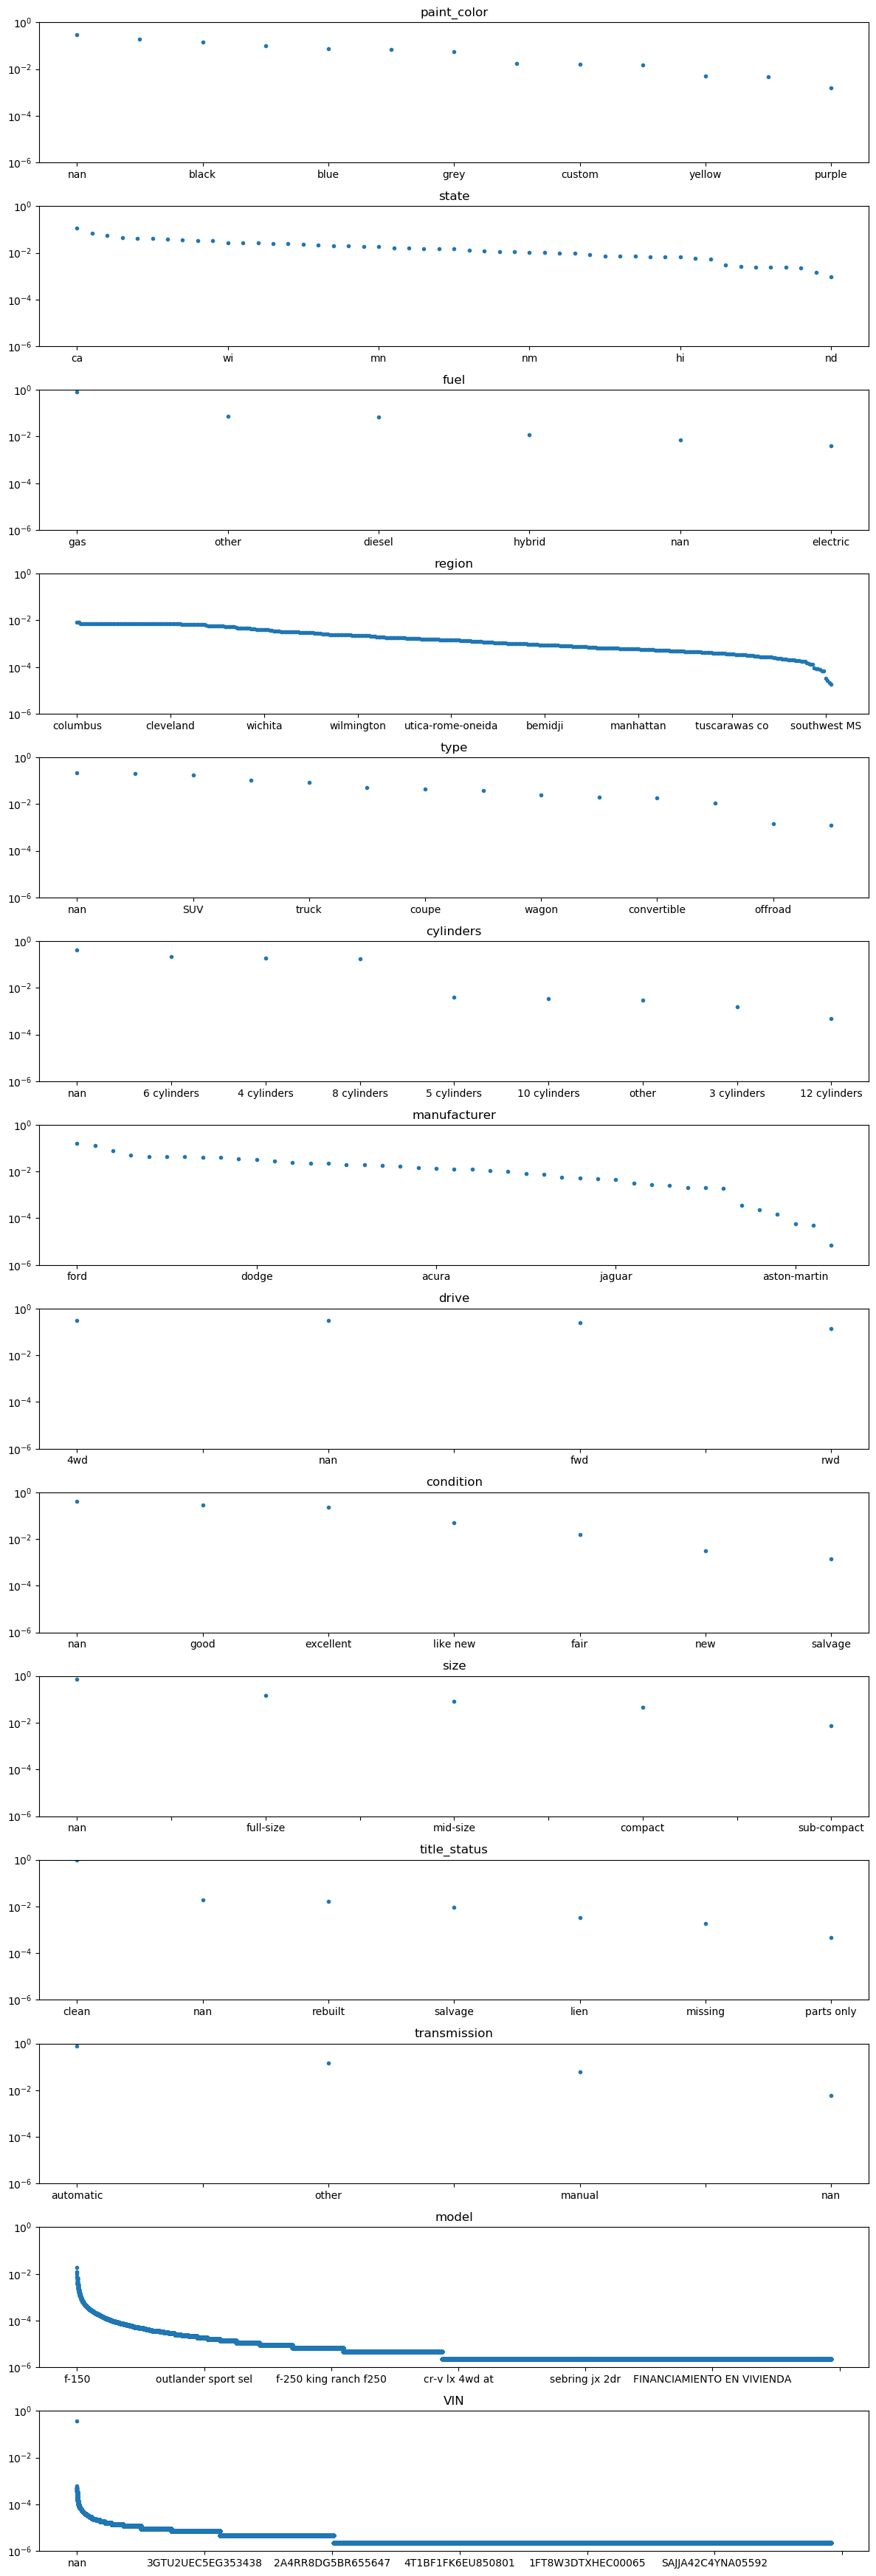

In [15]:
cols_non_numerical = set(df.select_dtypes(exclude=["number"]).columns) - set(["url", "region_url", "image_url", "description", "posting_date"]) 
nrows = len(cols_non_numerical)

# value ratio of each feature
fig, axs = plt.subplots(ncols=1, nrows=nrows, figsize=(12, 2.5*nrows))

for col, ax in zip(cols_non_numerical, axs.ravel()):    
    df[col].value_counts(normalize=True, dropna=False).plot(
        logy=True, title=col, lw=0, marker=".", ax=ax
    )
    ax.set_ylim(1e-6, 1)
plt.tight_layout()
plt.show()

In [68]:
display(df["model"].value_counts().sort_index()[:25])
display(df["model"].value_counts().sort_index()[-25:])

"t"                                                                                       1
$362.47, $1000 down, oac, 2.9%apr $362.47,luxury low miles $1000 down, only 40k miles     1
%                                                                                         1
& altima                                                                                  1
'50 Business Coupe                                                                        1
'99 H1 Hummer                                                                             1
(210)                                                                                     1
(300)                                                                                     1
(cng) 2500 express van                                                                    1
(s)port (s)edan                                                                           1
* vmi * ♿                                                                       

z4 sdrive28i                                             4
z4 sdrive28i roadster 2d                                35
z4 sdrive30i roadster 2d                                 4
z4 sdrive35i                                             3
z4 sdrive35i convertible sport premium m pkg leather     1
z4 sdrive35is                                            2
z4 sdrive35is roadster 2d                               97
z4 z3 tt z 330ci sc430                                   1
z600                                                     1
z71                                                      4
zdm                                                      1
zdx                                                      4
zephyr                                                  18
zephyr 4dr sdn                                           1
zj                                                       1
zl1 camaro                                               2
zr2 sonoma                                              

#### 2.2.3. Datetime features

In [16]:
df["posting_date"] = pd.to_datetime(df["posting_date"], utc=True)
df["posting_date"].min(), df["posting_date"].max()

(Timestamp('2021-04-04 07:00:25+0000', tz='UTC'),
 Timestamp('2021-05-05 04:24:09+0000', tz='UTC'))

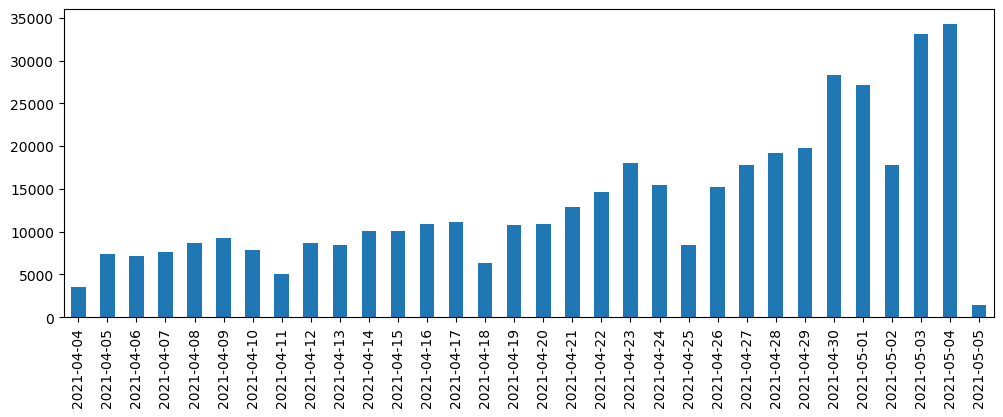

In [17]:
date_count = df["posting_date"].dt.date.value_counts().sort_index()
date_count.plot.bar(figsize=(12,4))
plt.show()

## 3. Content

### 3.1. Feature patterns

#### 3.1.1. Continuous features

In [18]:
cols_continuous = df.select_dtypes(include="number").nunique() > 25
cols_continuous

id           True
price        True
year         True
odometer     True
county      False
lat          True
long         True
dtype: bool

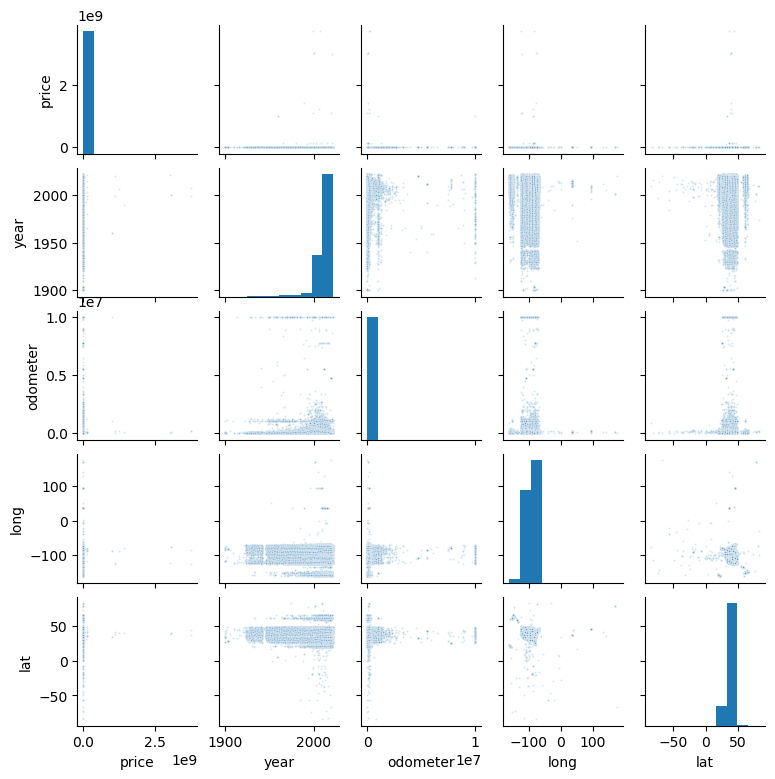

In [20]:
cols_continuous = ["price", "year", "odometer", "long", "lat"]
df_continuous = df[cols_continuous]

sns.pairplot(df_continuous, height=1.5, plot_kws={"s":2, "alpha":0.2})
plt.show()

#### 3.1.2. Discrete features

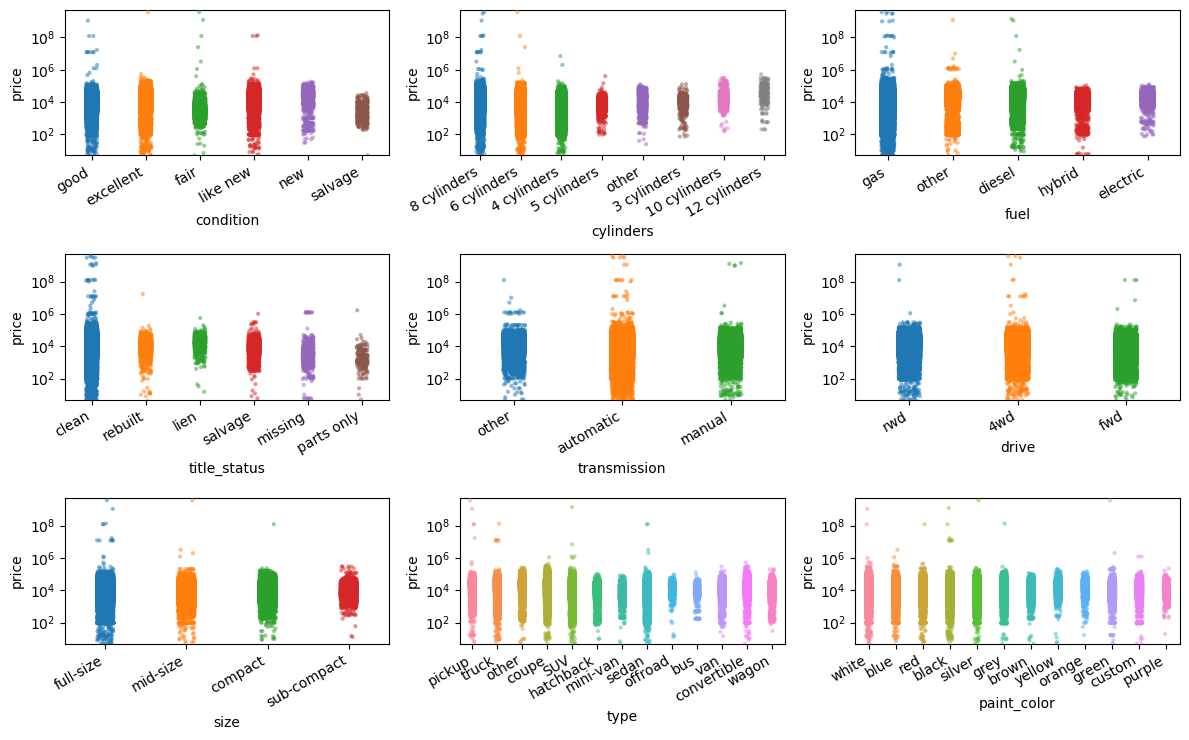

In [51]:
cols_discrete = df.select_dtypes(exclude="number").nunique() < 25
col_x = cols_discrete[cols_discrete].index

col_y = "price"

n_cols = 3
n_elements = len(col_x)
n_rows = np.ceil(n_elements / n_cols).astype("int")

fig, axs = plt.subplots(
    ncols=n_cols, nrows=n_rows, figsize=(12, n_rows*2.5)
)

for col, ax in zip(col_x, axs.ravel()):
    sns.stripplot(
        data=df, x=col, y=col_y, ax=ax, size=3, alpha=0.5
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_yscale("log")
    ax.set_ylim(5, 5e9)

plt.tight_layout()
plt.show()

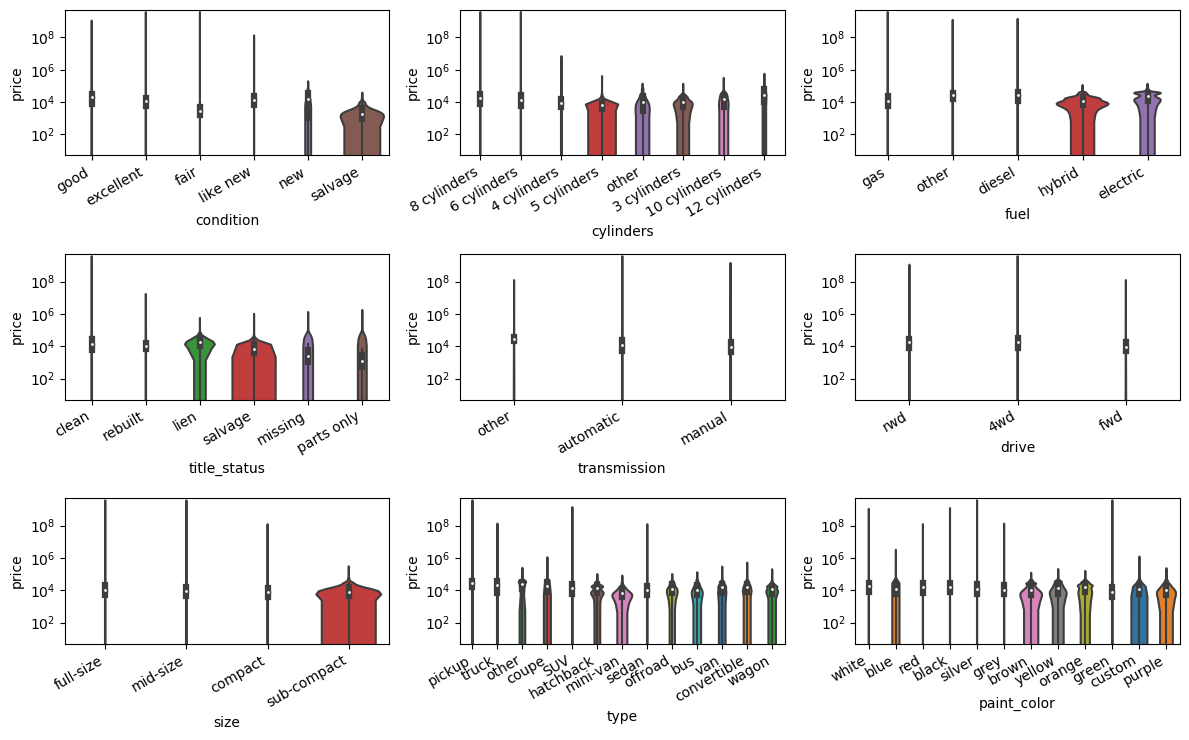

In [53]:
cols_discrete = df.select_dtypes(exclude="number").nunique() < 25
col_x = cols_discrete[cols_discrete].index

col_y = "price"

n_cols = 3
n_elements = len(col_x)
n_rows = np.ceil(n_elements / n_cols).astype("int")

fig, axs = plt.subplots(
    ncols=n_cols, nrows=n_rows, figsize=(12, n_rows*2.5)
)

for col, ax in zip(col_x, axs.ravel()):
    sns.violinplot(
        data=df, x=col, y=col_y, ax=ax, palette="tab10"
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_yscale("log")
    ax.set_ylim(5, 5e9)

plt.tight_layout()
plt.show()

### 3.2. Feature relationships

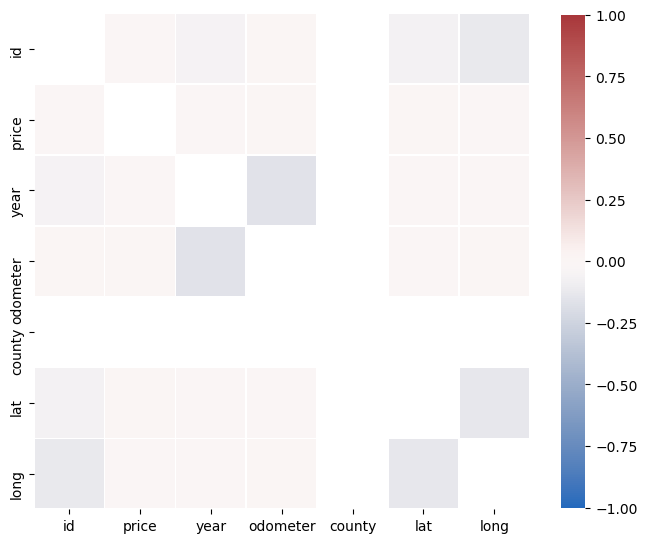

In [69]:
df_corr = df.corr(method="pearson")

labels = np.where(np.abs(df_corr)>0.75, "S", 
                 np.where(np.abs(df_corr)>0.5, "M",
                         np.where(np.abs(df_corr)>0.25, "W", "")))

plt.figure(figsize=(8,8))
sns.heatmap(
    df_corr, mask=np.eye(len(df_corr)), 
    square=True, center=0, 
    annot=labels, fmt="", 
    linewidths=.5, cmap="vlag", 
    cbar_kws={"shrink":0.8}, vmin=-1, vmax=1
)
plt.show()

* few numerical features 
* non-significant correlation